In [2]:
cd Deep\ active\ contours

[Errno 2] No such file or directory: 'Deep active contours'
/home/ahabis/3-Deep_active_contour


In [3]:
import SimpleITK as sitk
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, pairwise_distances
from sklearn.linear_model import LinearRegression
from radiomics import featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor('glcm.yaml')
import re
from operator import itemgetter
from pyfeats import correlogram
from config import *
from scipy.ndimage import distance_transform_edt

In [4]:
def process_score(x):
    x = re.sub(' +', ',',x)
    x = x.replace('nan','0')
    return np.array(eval(x))

In [45]:
scores = pd.read_csv('scores.csv', index_col=0)
energies = np.stack(scores['energy'].apply(process_score)).reshape(scores.shape[0],-1)
energies_mask = np.stack(scores['score'].apply(process_score))
data =  np.concatenate([energies_mask[:,-1][:,None],energies_mask[:,-2][:,None]],-1)
score = np.dot(data,np.array([0.4,0.6]))


In [46]:
n_iter = 10000
eps = 1e-8
precision ,recall, recognition, pq  = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
ts = np.linspace(0,1,n_iter)
dice = scores['DICE(%)']
for i, t in enumerate(ts):
    
    index_tp = np.argwhere(np.logical_and(score>t, gt.astype('bool'))).flatten()
    tp = np.sum((score>t).astype(int) * gt)
    tn = np.sum((score<t).astype(int) * (1 - gt))
    fp = np.sum((score>t).astype(int) * (1 - gt))
    fn = np.sum((score<t).astype(int) * (gt))
    dice_tmp = np.mean(dice[index_tp]/100)
    
    precision[i] =   np.sum(tp) / (np.sum(tp) + np.sum(fp) + eps) 
    recall[i] =   np.sum(tp) / (np.sum(tp) + np.sum(fn) + eps) 
    recognition[i] =   2 * precision[i]*recall[i]/(precision[i]+ recall[i]+eps)
    pq[i] = recognition[i] * dice_tmp  

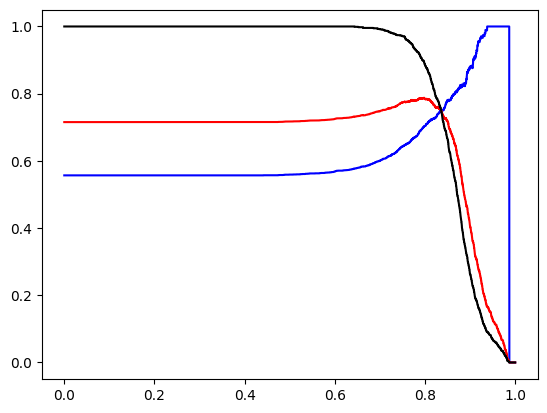

In [47]:
plt.plot(ts,precision, color = 'blue')
plt.plot(ts,recognition, color = 'red')
plt.plot(ts,recall, color = 'k')


81.90721153846154
0.7038917089618961
0.7878787829425112
0.8946236559043589


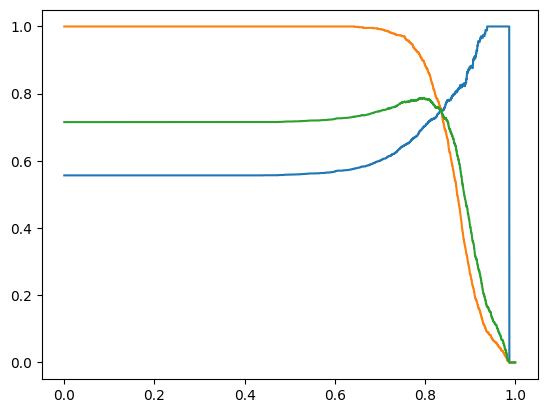

In [48]:
plt.plot(ts,precision)
plt.plot(ts,recall)
plt.plot(ts,recognition)
index = np.argmax(recognition)
threshold = ts[index]
pred = np.array(score>threshold).astype(int)
dices = np.array(scores['DICE(%)'])
print(np.sum(dices*pred*gt)/np.sum(pred*gt))
print(precision[index])
print(recognition[index])
print(recall[index])


In [49]:
ids = [480,487,477,474,469,468,465,463,462,457,456,453,451,450,449,447,439,486,416,413]

In [ ]:
images = (np.load('HEs.npy')*255).astype(int)
gts = np.load('gt.npy')
terms = np.load('terms.npy')
indexes = terms !='glomeruli'
gt = (terms == 'dilated_tubule').astype(int)
masks = np.load('gt.npy')

In [ ]:
# correlograms = []
# features_glcm = np.zeros((images.shape[0], 24))

# for index in range (images.shape[0]):
#     img = images[index][:,:,0,None].T
#     mask = gts[index, :, :, None].astype(np.int).T
    
#     img_sitk = sitk.GetImageFromArray(img)
#     mask_sitk = sitk.GetImageFromArray(mask)

#     result = extractor.execute(img_sitk, mask_sitk)
#     keys = [u for u in result.keys() if u.startswith('original')]
#     myvalues = itemgetter(*keys)(result)
#     features = (np.stack(list(myvalues)))
#     features_glcm[index] = features
#     correlograms.append(correlogram(images[index][:,:,0], masks[index],bins_digitize=16))

In [ ]:
# anchor = 480
# correlograms_used = np.stack(correlograms).reshape(-1,16*32)

In [ ]:
# anchors = [480,487,477,474,469,468,465,463,462,457,456,453,451,450,449,447,439,486,416,413]
# # anchors = [487]

# correlograms_used = np.stack(correlograms).reshape(-1,16*32)
# coeffs = np.zeros((len(anchors),25))
# total = np.zeros((len(anchors),np.sum(indexes),25))

# for i, anchor in enumerate(anchors):
#     x = np.minimum(features_glcm, features_glcm[anchor][None])/np.maximum(features_glcm, features_glcm[anchor][None])
#     y = np.sum(np.minimum(correlograms_used, correlograms_used[anchor][None]),axis = -1)/(np.sum(np.maximum(correlograms_used, correlograms_used[anchor][None]), axis = -1))
#     y = y[indexes]
#     x = x[indexes]

#     total[i,:,:-1] = x
#     total[i,:,-1] = y
    
# total = total.reshape(-1,25)
# fin = np.repeat(gt[indexes],len(anchors))
# reg = LinearRegression(fit_intercept=False, positive=True)
# reg.fit(total,fin)
# coeffs = reg.coef_

In [ ]:
fin = np.repeat(gt[indexes],len(anchors))
reg = LinearRegression(fit_intercept=False, positive=True)

NameError: name 'anchors' is not defined

In [ ]:
coeffs = (coeffs>0).astype(int)
coeffs = coeffs/np.sum(coeffs)
final = (total @ coeffs)


In [ ]:
threshs = np.linspace(0,1,10000)
mean_precisions = np.zeros(1000)
mean_recalls = np.zeros(1000)
precisions = np.zeros(1000)
recalls = np.zeros(1000)
f1s = np.zeros(1000)

for i, thresh in enumerate(threshs):
    thresh_score = final>thresh
    
    tp = np.sum(thresh_score * fin)
    fn = np.sum(thresh_score * (1 - fin))
    fp = np.sum((1 - thresh_score) * fin)
    tn = np.sum((1 - thresh_score) * (1 - fin))
    mean_precisions[i] = 0.5 * tp/(tp+fn + 1e-5) + 0.5 * tn/(tn+fp + 1e-5)
    mean_recalls[i] = 0.5 * tp/(tp+fp + 1e-5) +  0.5 * tn/(tn+fn + 1e-5)
    precisions[i] =  tp/(tp+fn + 1e-5) 
    recalls[i] =  tp/(tp+fp + 1e-5) 
    f1s[i] = 2 * (mean_precisions[i] * mean_recalls[i])/(mean_precisions[i] + mean_recalls[i])
    

IndexError: index 1000 is out of bounds for axis 0 with size 1000

0
0.6594724216669829
0.9999999990909091


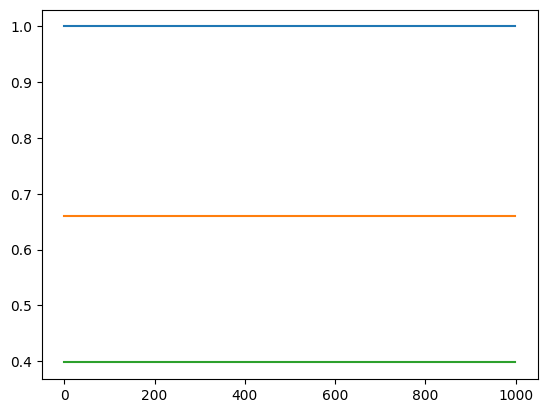

In [ ]:
plt.plot(np.arange(recalls.shape[0]),recalls)
plt.plot(np.arange(precisions.shape[0]),precisions)
plt.plot(np.arange(precisions.shape[0]),f1s)
arg = np.argmax(f1s)
print(arg)
print(precisions[arg])
print(recalls[arg])

In [ ]:
df = pd.read_csv('scores.csv', index_col=0)
df = df.replace(to_replace=['dilated_tubule', 'false_dilated_tubule','glomeruli'], value=[1,0,-1])
df = df[df['gt'].isin([0,1])].reset_index(drop=True)

In [ ]:

x = []

for i in range(10):
    df_test, df_validation = test_val_split(df, percentage = 0.2)
    thresh, coeffs = calculate_hyperparameters(df_validation)
    x.append(coeffs)


In [ ]:
df_test, df_validation = test_val_split(df, percentage = 0.2)

# coeffs = np.mean(np.stack(x),0)
coeffs = np.zeros(15)
coeffs[-1] = 0.8
coeffs[0] = 0.2

In [ ]:
stack = np.zeros((1,7))
for i, un in enumerate(np.unique(df_test['nb_anchor'])):
    df_test_anchor = df_test[df_test['nb_anchor']==un].reset_index(drop=True)
    score = np.stack(df_test_anchor['score'].apply(process_score))
    score = np.sum(score*coeffs,-1)
    stack[i] = np.array(compute_scores(score, df_test_anchor,thresh))

In [ ]:
stack

array([[0.73926868, 0.95092025, 0.83621008, 0.66248302, 0.73008166,
        0.83184258, 0.60731301]])